<center>

<div align="center">
    <img src="../Images/javeriana.PNG" width="800" height="600">
</div>

**Juan David Villate Lemus**

**José Rafael Peña Gutiérrez**

**Laura Katherine Moreno Giraldo**

**William Ricardo Fernández Garnica**

# Exercise 3
## Spam Classification
### Context
The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

### Content
The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

This corpus has been collected from free or free for research sources at the Internet:

- A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages. The Grumbletext Web site is: [Web Link](http://www.grumbletext.co.uk/).
- A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. The NUS SMS Corpus is avalaible at: [Web Link](http://www.comp.nus.edu.sg/~rpnlpir/downloads/corpora/smsCorpus/).
- A list of 450 SMS ham messages collected from Caroline Tag's PhD Thesis available at [Web Link](http://etheses.bham.ac.uk/253/1/Tagg09PhD.pdf).
- Finally, we have incorporated the SMS Spam Corpus v.0.1 Big. It has 1,002 SMS ham messages and 322 spam messages and it is public available at: [Web Link](http://www.esp.uem.es/jmgomez/smsspamcorpus/). This corpus has been used in the following academic researches:

Acknowledgements
The original dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). The creators would like to note that in case you find the dataset useful, please make a reference to previous paper and the web page: http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/ in your papers, research, etc.

We offer a comprehensive study of this corpus in the following paper. This work presents a number of statistics, studies and baseline results for several machine learning methods.

Almeida, T.A., GÃ³mez Hidalgo, J.M., Yamakami, A. Contributions to the Study of SMS Spam Filtering: New Collection and Results. Proceedings of the 2011 ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA, 2011.

In [1]:
pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=a31bdcffe6885bce8a62654d6e289acd90fcf9bb85ab3221c6a68f100bf6c784
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
import pandas as pd
import numpy as np
import wget
import os
from zipfile import ZipFile

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve

import gensim
from gensim.models import Word2Vec
import warnings

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# 
try :
    from google.colab import files
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
    !unzip smsspamcollection.zip
    df = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
except ModuleNotFoundError :
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    path = os.getcwd()+'\Data'
    wget.download(url,path)
    temp=path+'\smsspamcollection.zip'
    file = ZipFile(temp)
    file.extractall(path)
    file.close()
    df = pd.read_csv(path + '\SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])

--2024-03-23 01:33:59--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z     [ <=>                ] 198.65K  --.-KB/s    in 0.03s   

2024-03-23 01:33:59 (5.68 MB/s) - ‘smsspamcollection.zip’ saved [203415]

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [4]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
display(df.shape) #Number of rows (instances) and columns in the dataset
df["target"].value_counts()/df.shape[0] #Class distribution in the dataset

(5572, 2)

ham     0.865937
spam    0.134063
Name: target, dtype: float64

In [6]:
X = df['text']
y = df['target'].map({'ham':0, 'spam':1})

In [7]:
# split data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df['target'], test_size = 0.3, random_state = 18)

Preprocess the text data by removing stop words, converting all text to lowercase, and removing punctuation using NLTK package.


In [8]:
stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

Train a Word2Vec model on the preprocessed training data using Gensim package.

In [9]:
sentences = [sentence.split() for sentence in X_train]
model = Word2Vec(sentences, vector_size=100, window=5, negative=20, min_count=1, workers=4)

Convert the preprocessed text data to a vector representation using the Word2Vec model.

In [10]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])

Train a classification model such as logistic regression, random forests, or support vector machines using the vectorised training data and the sentiment labels.

In [11]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

Evaluate the performance of the classification model on the testing set with the accuracy, precision, recall and F1 score.

In [12]:
y_pred = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUC:', auc(fpr, tpr))

Accuracy: 0.8660287081339713
AUC: 0.5


# Excercise 3.1

Remove stopwords, then predict target using CountVectorizer.

use Random Forest classifier

In [13]:
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

In [15]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [16]:
y_pred = rf_classifier.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print('AUC:', auc(fpr, tpr))

Accuracy: 0.9802690582959641
AUC: 0.9261744966442953


# Excercise 3.2

Predict target using TdidfVectorizer.

use Random Forest classifier

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [19]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [20]:
y_pred = rf_classifier.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print('AUC:', auc(fpr, tpr))

Accuracy: 0.979372197309417
AUC: 0.9228187919463087


# Excercise 3.3

Predict target using CountVectorizer or TfideVectorizer.

choose any classification model and justify why

In [21]:
# SVM es un modelo sencillo y rápido para problemas de clasificación y funcionan bien con espacios multidimensionales. Incluso se puede notar en la velocidad del procesamiento en la clasificación para este caso obteniendo muy buenos resultados.

from sklearn.svm import SVC
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [22]:
y_pred =svm_classifier.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print('AUC:', auc(fpr, tpr))

Accuracy: 0.9901345291479821
AUC: 0.9630872483221476


# Excercise 3.4

Increase and decrece the parameters values vector_size, window and negative then predict the target.

Plot the different values of the parameters with the performance of the model.

Use a Random Forest classifier and classification model of your choice and justify why.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df['target'], test_size = 0.3, random_state = 18)
sentences = [sentence.split() for sentence in X_train]
model = Word2Vec(sentences, vector_size=100, window=5, negative=20, min_count=1, workers=4)

In [24]:
X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])

In [25]:
#Random Forest

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [26]:
y_pred_proba_rf = rf_classifier.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

In [27]:
#SVM

svm_classifier = SVC(kernel='linear', probability = True, random_state=42)
svm_classifier.fit(X_train, y_train)
y_pred_proba_svm = svm_classifier.predict_proba(X_test)[:, 1]
fpr_svm, tpr_svm, thresholds = roc_curve(y_test, y_pred_proba_svm)

In [28]:
#Curva ROC SVM
roc_auc_svm = auc(fpr_svm, tpr_svm)

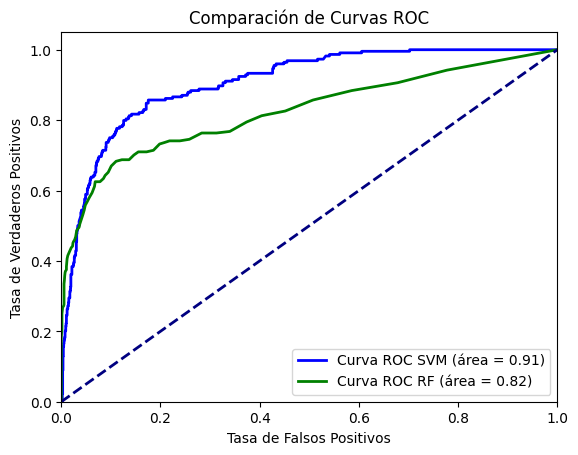

In [29]:
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label=f'Curva ROC SVM (área = {roc_auc_svm:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Curva ROC RF (área = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Comparación de Curvas ROC')
plt.legend(loc="lower right")
plt.show()

parameter variation: `vector_size`

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df['target'], test_size = 0.3, random_state = 18)
X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

In [31]:
#De 100 lo pasé a 200 y a 50
sentences = [sentence.split() for sentence in X_train]
model2 = Word2Vec(sentences, vector_size=500, window=5, negative=20, min_count=1, workers=4)
model3 = Word2Vec(sentences, vector_size=50, window=5, negative=20, min_count=1, workers=4)

In [32]:
def vectorize2(sentence):
    words = sentence.split()
    words_vecs = [model2.wv[word] for word in words if word in model.wv]
    if len(words_vecs) == 0:
        return np.zeros(500)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

def vectorize3(sentence):
    words = sentence.split()
    words_vecs = [model3.wv[word] for word in words if word in model.wv]
    if len(words_vecs) == 0:
        return np.zeros(50)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train_500 = np.array([vectorize2(sentence) for sentence in X_train])
X_test_500 = np.array([vectorize2(sentence) for sentence in X_test])

X_train_50 = np.array([vectorize3(sentence) for sentence in X_train])
X_test_50 = np.array([vectorize3(sentence) for sentence in X_test])

In [33]:
svm_classifier_500 = SVC(kernel='linear', probability = True, random_state=42)
svm_classifier_500.fit(X_train_500, y_train)
y_pred_proba_svm_500 = svm_classifier_500.predict_proba(X_test_500)[:, 1]
fpr_svm_500, tpr_svm_500, thresholds = roc_curve(y_test, y_pred_proba_svm_500)

In [34]:
svm_classifier_50 = SVC(kernel='linear', probability = True, random_state=42)
svm_classifier_50.fit(X_train_50, y_train)
y_pred_proba_svm_50 = svm_classifier_50.predict_proba(X_test_50)[:, 1]
fpr_svm_50, tpr_svm_50, thresholds = roc_curve(y_test, y_pred_proba_svm_50)

In [35]:
roc_auc_svm_500 = auc(fpr_svm_500, tpr_svm_500)
roc_auc_svm_50 = auc(fpr_svm_50, tpr_svm_50)

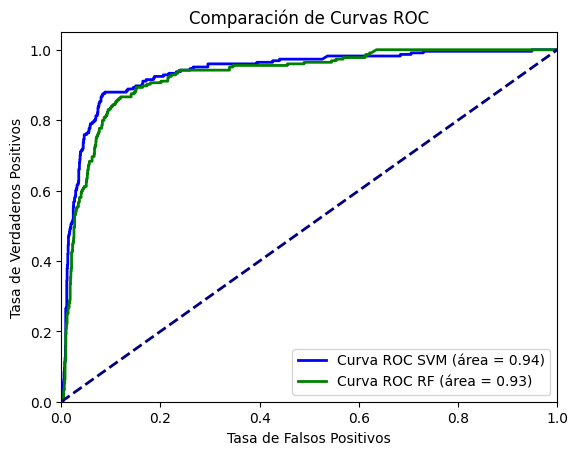

In [36]:
plt.figure()
plt.plot(fpr_svm_500, tpr_svm_500, color='blue', lw=2, label=f'Curva ROC SVM (área = {roc_auc_svm_500:.2f})')
plt.plot(fpr_svm_50, tpr_svm_50, color='green', lw=2, label=f'Curva ROC RF (área = {roc_auc_svm_50:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Comparación de Curvas ROC')
plt.legend(loc="lower right")
plt.show()

#No se ve un efecto muy grande en el cambio del tamaño del vector cuando lo observamos en una curva ROC.

parameter variation: `window`

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df['target'], test_size = 0.3, random_state = 18)
X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

sentences = [sentence.split() for sentence in X_train]
model4 = Word2Vec(sentences, vector_size=100, window=4, negative=20, min_count=1, workers=4)
model5 = Word2Vec(sentences, vector_size=100, window=8, negative=20, min_count=1, workers=4)


def vectorize4(sentence):
    words = sentence.split()
    words_vecs = [model4.wv[word] for word in words if word in model4.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

def vectorize5(sentence):
    words = sentence.split()
    words_vecs = [model5.wv[word] for word in words if word in model5.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train_4 = np.array([vectorize4(sentence) for sentence in X_train])
X_test_4 = np.array([vectorize4(sentence) for sentence in X_test])

X_train_5 = np.array([vectorize5(sentence) for sentence in X_train])
X_test_5 = np.array([vectorize5(sentence) for sentence in X_test])

In [39]:
svm_classifier_4 = SVC(kernel='linear', probability = True, random_state=42)
svm_classifier_4.fit(X_train_4, y_train)
y_pred_proba_svm_4 = svm_classifier_4.predict_proba(X_test_4)[:, 1]
fpr_svm_4, tpr_svm_4, thresholds = roc_curve(y_test, y_pred_proba_svm_4)

In [40]:
svm_classifier_5 = SVC(kernel='linear', probability = True, random_state=42)
svm_classifier_5.fit(X_train_5, y_train)
y_pred_proba_svm_5 = svm_classifier_5.predict_proba(X_test_5)[:, 1]
fpr_svm_5, tpr_svm_5, thresholds = roc_curve(y_test, y_pred_proba_svm_5)

In [41]:
roc_auc_svm_4 = auc(fpr_svm_4, tpr_svm_4)
roc_auc_svm_5 = auc(fpr_svm_5, tpr_svm_5)

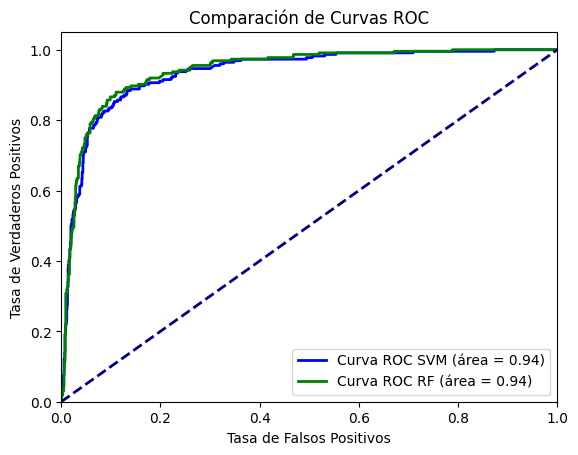

In [42]:
plt.figure()
plt.plot(fpr_svm_4, tpr_svm_4, color='blue', lw=2, label=f'Curva ROC SVM (área = {roc_auc_svm_4:.2f})')
plt.plot(fpr_svm_5, tpr_svm_5, color='green', lw=2, label=f'Curva ROC RF (área = {roc_auc_svm_5:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Comparación de Curvas ROC')
plt.legend(loc="lower right")
plt.show()

#Con un tamaño de 4 parece mejorar sobre un tamaño más grande como 8

parameter variation: `negative`

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df['target'], test_size = 0.3, random_state = 18)
X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

sentences = [sentence.split() for sentence in X_train]
model6 = Word2Vec(sentences, vector_size=100, window=4, negative=10, min_count=1, workers=4)
model7 = Word2Vec(sentences, vector_size=100, window=8, negative=30, min_count=1, workers=4)


def vectorize6(sentence):
    words = sentence.split()
    words_vecs = [model6.wv[word] for word in words if word in model6.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

def vectorize7(sentence):
    words = sentence.split()
    words_vecs = [model7.wv[word] for word in words if word in model7.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train_6 = np.array([vectorize6(sentence) for sentence in X_train])
X_test_6 = np.array([vectorize6(sentence) for sentence in X_test])

X_train_7 = np.array([vectorize7(sentence) for sentence in X_train])
X_test_7 = np.array([vectorize7(sentence) for sentence in X_test])

In [44]:
svm_classifier_6 = SVC(kernel='linear', probability = True, random_state=42)
svm_classifier_6.fit(X_train_6, y_train)
y_pred_proba_svm_6 = svm_classifier_6.predict_proba(X_test_6)[:, 1]
fpr_svm_6, tpr_svm_6, thresholds = roc_curve(y_test, y_pred_proba_svm_6)

In [45]:
svm_classifier_7 = SVC(kernel='linear', probability = True, random_state=42)
svm_classifier_7.fit(X_train_7, y_train)
y_pred_proba_svm_7 = svm_classifier_7.predict_proba(X_test_7)[:, 1]
fpr_svm_7, tpr_svm_7, thresholds = roc_curve(y_test, y_pred_proba_svm_7)

In [48]:
roc_auc_svm_6 = auc(fpr_svm_6, tpr_svm_6)
roc_auc_svm_7 = auc(fpr_svm_7, tpr_svm_7)

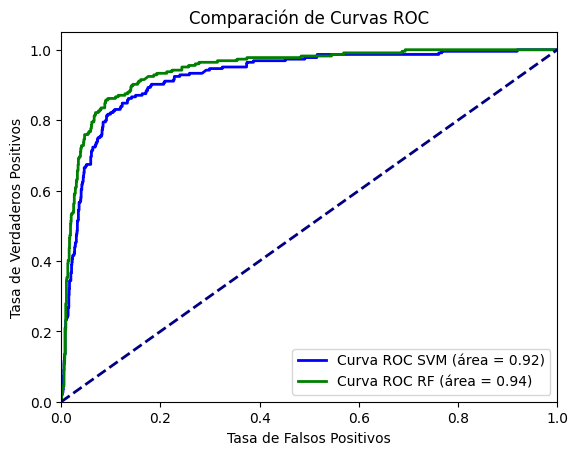

In [49]:
plt.figure()
plt.plot(fpr_svm_6, tpr_svm_6, color='blue', lw=2, label=f'Curva ROC SVM (área = {roc_auc_svm_6:.2f})')
plt.plot(fpr_svm_7, tpr_svm_7, color='green', lw=2, label=f'Curva ROC RF (área = {roc_auc_svm_7:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Comparación de Curvas ROC')
plt.legend(loc="lower right")
plt.show()

Running best parameters `vector_size, window and negative` (All at the same time)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df['target'], test_size = 0.3, random_state = 18)
X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

sentences = [sentence.split() for sentence in X_train]

model8 = Word2Vec(sentences, vector_size=500, window=8, negative=30, min_count=1, workers=4)


def vectorize8(sentence):
    words = sentence.split()
    words_vecs = [model8.wv[word] for word in words if word in model8.wv]
    if len(words_vecs) == 0:
        return np.zeros(500)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train_8 = np.array([vectorize8(sentence) for sentence in X_train])
X_test_8 = np.array([vectorize8(sentence) for sentence in X_test])

In [51]:
svm_classifier_8 = SVC(kernel='linear', probability = True, random_state=42)
svm_classifier_8.fit(X_train_8, y_train)
y_pred_proba_svm_8 = svm_classifier_8.predict_proba(X_test_8)[:, 1]
fpr_svm_8, tpr_svm_8, thresholds = roc_curve(y_test, y_pred_proba_svm_8)

In [52]:
roc_auc_svm_8 = auc(fpr_svm_8, tpr_svm_8)

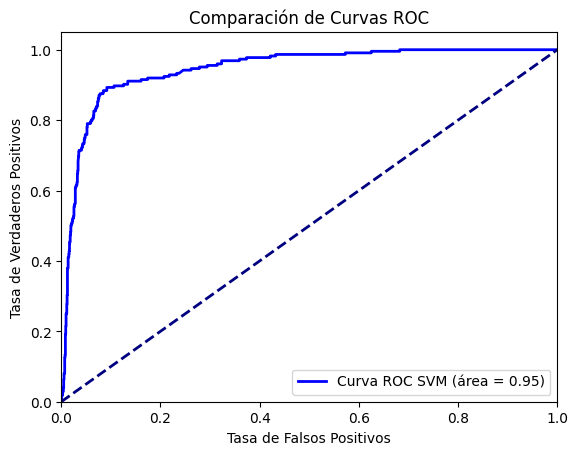

In [53]:
plt.figure()
plt.plot(fpr_svm_8, tpr_svm_8, color='blue', lw=2, label=f'Curva ROC SVM (área = {roc_auc_svm_8:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Comparación de Curvas ROC')
plt.legend(loc="lower right")
plt.show()